In [11]:
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
import matplotlib.pyplot as plt

import numpy as np
from temgymbasic.utils import calculate_phi_0, calculate_wavelength
import ase
import abtem
from matplotlib.patches import Circle
from ase.cluster import Decahedron
%matplotlib ipympl

In [12]:

def FresnelPropagator(E0, ps, lambda0, z):
    """
    Parameters:
        E0 : 2D array
            The initial complex field in the x-y source plane.
        ps : float
            Pixel size in the object plane (same units as wavelength).
        lambda0 : float
            Wavelength of the light (in the same units as ps).
        z : float
            Propagation distance (in the same units as ps).

    Returns:
        Ef : 2D array
            The complex field after propagating a distance z.
    """
    n, m = E0.shape

    fx = np.fft.fftfreq(n, ps)
    fy = np.fft.fftfreq(m, ps)
    Fx, Fy = np.meshgrid(fx, fy)

    H = np.exp(-1j * (2 * np.pi / lambda0) * z) * np.exp(-1j * np.pi * lambda0 * z * (Fx**2 + Fy**2))
    E0fft = np.fft.fft2(E0)
    G = H * E0fft
    Ef = np.fft.ifft2(G)

    return Ef


def zero_phase(u, idx_x):
    u_centre = u[idx_x]
    phase_difference = 0 - np.angle(u_centre)
    u = u * np.exp(1j * phase_difference)
    return u


In [21]:
# Configure potential
phi = 100e3

wavelength = calculate_wavelength(phi) * 1e10
n_rays = 1

k = 2 * np.pi / wavelength

wavelengths = np.full(n_rays, wavelength)
pixel_size = 0.1

wo = 2
wos = np.full(n_rays, wo)

amplitude = 1.0
div = wavelength / (np.pi * wo)

dPx = wo
dPy = wo
dHx = div
dHy = div

z_r = (np.pi * wo ** 2) / wavelengths

theta_x = 0
theta_y = 0

deg_yx = np.deg2rad((theta_y, theta_x))
tilt_yx = np.tan(deg_yx)

x0 = 0
y0 = 0

prop_dist = 1e-11

z_start = 5000
z_atoms = prop_dist

slice_thickness = 100
# sampling = pixel_size
# unit_cell = ase.build.bulk("Au", cubic=True)
# atoms = unit_cell * (10, 10, 10)
# potential = abtem.Potential(
#     atoms,
#     slice_thickness=slice_thickness,
#     sampling=sampling,
#     # projection="infinite",
# )

cluster = Decahedron("Cu", 9, 2, 0)
cluster.rotate("x", -30)
substrate = ase.build.bulk("C", cubic=True)

# repeat diamond structure
substrate *= (12, 12, 10)

# displace atoms with a standard deviation of 50 % of the bond length
bondlength = 1.54  # Bond length
substrate.positions[:] += np.random.randn(len(substrate), 3) * 0.5 * bondlength

# wrap the atoms displaced outside the cell back into the cell
substrate.wrap()

translated_cluster = cluster.copy()

translated_cluster.cell = substrate.cell
translated_cluster.center()
translated_cluster.translate((0, 0, -25))

atoms = substrate + translated_cluster

atoms.center(axis=2, vacuum=2)


potential = abtem.Potential(
    atoms,
    gpts=128,
    slice_thickness=slice_thickness,
)

pixel_size = potential.sampling[0]
phase_shift = np.asarray(potential.build().compute().transmission_function(phi).compute().array)
# phase_shift = np.sum(phase_shift, axis=0)
npix = phase_shift.shape[1]
det_shape = (npix, npix)

print(phase_shift.shape)
# extent = [0 - dsize / 2, 0 + dsize / 2, 0 - dsize / 2, 0 + dsize/2]

field = phase_shift

components = (
    comp.GaussBeam(
        z=z_atoms-1e-11,
        voltage=calculate_phi_0(wavelength),
        radius=x0,
        wo=wos,
        amplitude=amplitude,
        tilt_yx=tilt_yx,
        random_subset=n_rays,
        offset_yx=(0, 0)
    ),
    comp.Detector(
        z=z_atoms,
        pixel_size=pixel_size,
        shape=det_shape,
        interference='gauss'
    ),
)
model = Model(components, backend='cpu')
rays = tuple(model.run_iter(num_rays=n_rays))
gbd_input_field = model.detector.get_image(rays[-1])

gaussian_wave = abtem.Waves(
    array=gbd_input_field.copy(), energy=phi, sampling=pixel_size
)

exit_wave = gaussian_wave.multislice(potential)
exit_wave.compute()
detector_field = exit_wave.array


[                                        ] | 0% Completed | 448.33 us

[########################################] | 100% Completed | 204.70 ms
(1, 128, 128)


/home/dl277493/TemGym/src/temgymbasic/utils.py:320: RuntimeWarning: invalid value encountered in sqrt
  radius * xp.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))


In [22]:
exit_wave.array

array([[ 2.80379591e-05+9.17926882e-05j,  7.40233809e-05-3.63698273e-05j,
         2.59870631e-05-1.09520748e-04j, ...,
         9.12324540e-05-7.78434915e-05j, -6.11827199e-05-7.68219033e-05j,
        -7.61454867e-05+5.97976286e-05j],
       [-2.39283945e-05+5.15449319e-05j, -7.18644878e-05+8.55443577e-05j,
         5.69325630e-06-4.15650247e-05j, ...,
        -7.13313566e-05+5.33083658e-05j,  2.35729694e-05-6.64311519e-05j,
         5.91632779e-05-6.97425712e-05j],
       [-2.33877472e-05-9.48463348e-05j, -7.26000217e-05+5.59379732e-05j,
        -4.90525308e-05+1.18166725e-04j, ...,
        -1.19385055e-04+7.76969682e-05j,  8.03137082e-05+7.51273692e-05j,
         8.72238088e-05-6.85825507e-05j],
       ...,
       [-7.36022630e-05+2.86962004e-05j,  4.09770619e-05+9.79735050e-05j,
         5.65304726e-05-1.50622727e-05j, ...,
         3.67320972e-05+9.38190278e-05j,  1.15083043e-04-4.57007955e-05j,
        -2.90615208e-05-9.80506375e-05j],
       [-6.63951050e-06-1.08027773e-04j, -9.

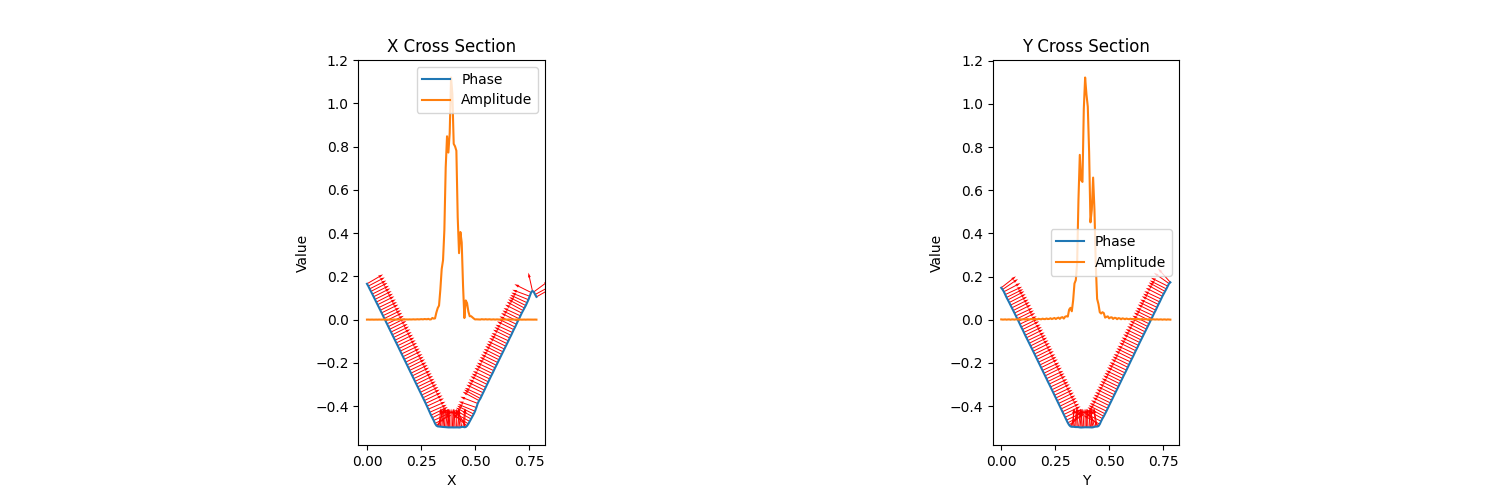

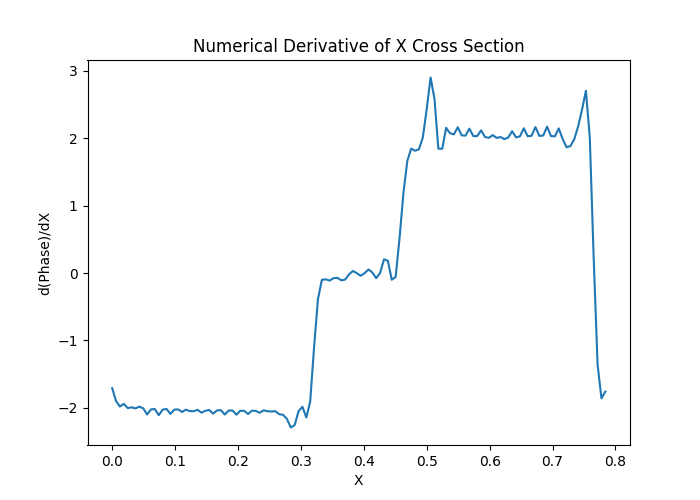

In [24]:
from skimage.restoration import unwrap_phase
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
# fig, axs = plt.subplots(1, 2, figsize=(10, 15))

# # Second row
# axs[0].imshow(np.abs(detector_field), cmap='gray')
# axs[0].set_title('Multislice Method Amplitude')

# axs[1].imshow(np.angle(detector_field), cmap='gray')
# axs[1].set_title('Multislice Method Phase')

unwrapped_phase = unwrap_phase(np.angle(detector_field)) / k
X, Y = np.meshgrid(np.arange(unwrapped_phase.shape[1]) / k, np.arange(unwrapped_phase.shape[0]) / k)
# plt.figure()
# plt.imshow(unwrapped_phase, cmap='gray')
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(X, Y, unwrapped_phase, cmap='viridis')
# ax.set_title('Unwrapped Phase Surface Profile')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Phase')
# plt.show()
# plt.tight_layout()


# Plot the x and y cross sections of the unwrapped phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


unwrapped_phase = gaussian_filter(unwrapped_phase, sigma=1)

# X cross section at the middle of the Y axis
mid_y = unwrapped_phase.shape[0] // 2
ax1.plot(X[mid_y, :], unwrapped_phase[mid_y, :], label='Phase')
ax1.plot(X[mid_y, :], np.abs(detector_field[mid_y, :]), label='Amplitude')
ax1.set_title('X Cross Section')
ax1.set_xlabel('X')
ax1.set_ylabel('Value')
ax1.legend()

# Y cross section at the middle of the X axis
mid_x = unwrapped_phase.shape[1] // 2
ax2.plot(Y[:, mid_x], unwrapped_phase[:, mid_x], label='Phase')
ax2.plot(Y[:, mid_x], np.abs(detector_field[:, mid_x]), label='Amplitude')
ax2.set_title('Y Cross Section')
ax2.set_xlabel('Y')
ax2.set_ylabel('Value')
ax2.legend()

# Calculate the numerical derivative of the X cross section
dx = np.gradient(unwrapped_phase[mid_y, :], X[mid_y, :])
dy = np.gradient(unwrapped_phase[:, mid_x], Y[:, mid_x])
# Apply Gaussian filter to smoothen the unwrapped phase


fig, ax3 = plt.subplots(figsize=(7, 5))
ax3.plot(X[mid_y, :], dx)
ax3.set_title('Numerical Derivative of X Cross Section')
ax3.set_xlabel('X')
ax3.set_ylabel('d(Phase)/dX')

Dx = np.sqrt(dx**2 + 1)
S_nx = np.array([-dx / Dx, 1 / Dx])

Dy = np.sqrt(dy**2 + 1)
S_ny = np.array([-dy / Dy, 1 / Dy])

# Plot the surface normal vector onto the X cross section of the phase
ax1.quiver(X[mid_y, :], unwrapped_phase[mid_y, :], S_nx[0, :], S_nx[1, :], color='r', scale=10)
ax2.quiver(Y[:, mid_x], unwrapped_phase[:, mid_x], S_ny[0, :], S_ny[1, :], color='r', scale=10)
ax1.set_aspect('equal')
ax2.set_aspect('equal')